<a href="https://colab.research.google.com/github/wdon021/From_Colab/blob/master/ImageEnhancement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [2]:
!pip install torchvision==0.1.9
!pip install fastai==0.7.0
!pip install torchtext==0.2.3

     |████████████████████████████████| 51kB 1.7MB/s 
  Found existing installation: torchvision 0.4.2
    Uninstalling torchvision-0.4.2:
      Successfully uninstalled torchvision-0.4.2
     |████████████████████████████████| 122kB 2.8MB/s 
     |████████████████████████████████| 496.4MB 31kB/s 
     |████████████████████████████████| 1.5MB 50.0MB/s 
  Created wheel for bcolz: filename=bcolz-1.2.1-cp36-cp36m-linux_x86_64.whl size=2662744 sha256=0d9817ce311c94aba30279880bc60446a8ef7f1dd1084f5d3aaf757b3a56f770
  Stored in directory: /root/.cache/pip/wheels/9f/78/26/fb8c0acb91a100dc8914bf236c4eaa4b207cb876893c40b745
Successfully built bcolz
  Found existing installation: torch 1.3.1
    Uninstalling torch-1.3.1:
      Successfully uninstalled torch-1.3.1
  Found existing installation: fastai 1.0.60
    Uninstalling fastai-1.0.60:
      Successfully uninstalled fastai-1.0.60
     |████████████████████████████████| 51kB 1.7MB/s 
  Created wheel for torchtext: filename=torchtext-0.2.3-cp36

In [0]:
from fastai.conv_learner import *
from pathlib import Path
from scipy import ndimage
torch.backends.cudnn.benchmark=True

In [0]:
PATH = "/content/gdrive/My Drive/ImageEnhancement/"

In [0]:
PATH = Path('/content/gdrive/My Drive/ImageEnhancement')
PATH_TRN = PATH/'train'

In [6]:
m_vgg = to_gpu(vgg16(True)).eval()
set_trainable(m_vgg, False)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.torch/models/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:05<00:00, 99121735.76it/s] 


In [0]:
img_fn = PATH_TRN/'n01440764'/'20200102_214655.jpg'
img = open_image(img_fn)
img = np.rot90(img, k=1, axes=(0, 1))

In [0]:
sz=288

In [9]:
trn_tfms, val_tfms = tfms_from_model(vgg16, sz)
img_tfm = val_tfms(img)
img_tfm.shape

(3, 288, 288)

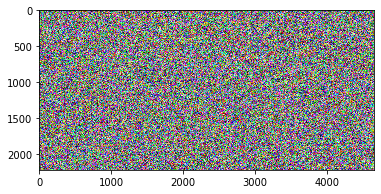

In [10]:
opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)
plt.imshow(opt_img)

In [0]:
opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])

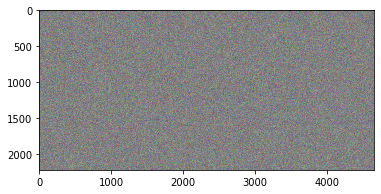

In [12]:
plt.imshow(opt_img)

In [13]:
opt_img = val_tfms(opt_img)/2
opt_img_v = V(opt_img[None], requires_grad=True)
opt_img_v.shape

torch.Size([1, 3, 288, 288])

In [0]:
m_vgg = nn.Sequential(*children(m_vgg)[:37])

In [15]:
targ_t = m_vgg(VV(img_tfm[None]))
targ_v = V(targ_t)
targ_t.shape

torch.Size([1, 512, 18, 18])

In [0]:

max_iter = 1000
show_iter = 100
optimizer = optim.LBFGS([opt_img_v], lr=0.5)

In [0]:
def actn_loss(x): return F.mse_loss(m_vgg(x), targ_v)*1000

In [0]:
def step(loss_fn):
    global n_iter
    optimizer.zero_grad()
    loss = loss_fn(opt_img_v)
    loss.backward()
    n_iter+=1
    if n_iter%show_iter==0: print(f'Iteration: {n_iter}, loss: {loss.data[0]}')
    return loss

In [19]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,actn_loss))

Iteration: 100, loss: 0.8452212810516357
Iteration: 200, loss: 0.4229978322982788
Iteration: 300, loss: 0.29975852370262146
Iteration: 400, loss: 0.24112504720687866
Iteration: 500, loss: 0.20588700473308563
Iteration: 600, loss: 0.18206898868083954
Iteration: 700, loss: 0.16599397361278534
Iteration: 800, loss: 0.1533944457769394
Iteration: 900, loss: 0.14262457191944122
Iteration: 1000, loss: 0.13437941670417786


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


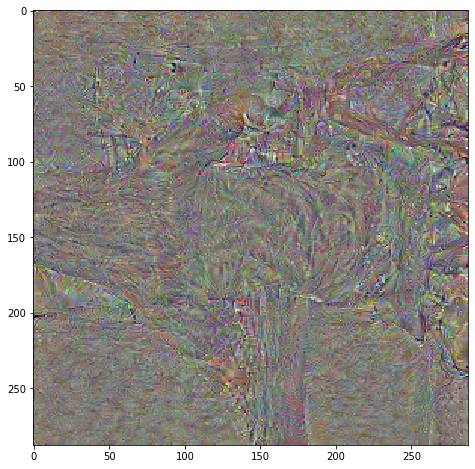

In [20]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(8,8))
plt.imshow(x)